In [1]:
# Imports
from os import makedirs
from os.path import join
import pickle
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.auto import tqdm
import sys
sys.path.append("..")

from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances

from utils import get_model_checkpoint_filepaths

In [2]:
# Get last word embeddings from training
checkpoint_filepaths_dict = get_model_checkpoint_filepaths(
    output_dir="../output/word2vec_training/17-Oct-2020_01-00-56",
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights_filepath = checkpoint_filepaths_dict["intermediate_embedding_weight_filepaths"][-1]
last_embedding_weights = np.load(last_embedding_weights_filepath, mmap_mode="r").astype(np.float64)

In [20]:
# Load words and create word to int lookup dict
with open(checkpoint_filepaths_dict["train_words_filepath"], "r") as file:
    words = np.array(file.read().split("\n"))
word_to_int = {word: i for i, word in enumerate(words)}

In [3]:
def cluster_hyperparameters_search(
    clusterers: list,
    clusterer_names: list,
    clusterer_hyperparam_grids: list,
    vocab_size: int,
    word_embeddings: np.ndarray,
    output_filepath_suffix: str,
    output_dir: str = None,
    model_name: str = None,
    dataset_name: str = None,
):
    """
    TODO: Docs
    """
    # Ensure output directory exists
    makedirs(output_dir, exist_ok=True)
    
    # Default to all words if -1
    if vocab_size == -1:
        vocab_size = len(word_embeddings)
    
    # Only fit/evaluate on max `vocab_size` words.
    word_embeddings_fit = word_embeddings[:vocab_size]
    word_embeddings_pairwise_dists = pairwise_distances(word_embeddings_fit)
    
    # Fit and predict cluster labels
    cluster_labels = {}
    for clusterer, clusterer_name, hyperparam_grid in zip(clusterers, clusterer_names, clusterer_hyperparam_grids):
        print(f"-- Fitting and predicting cluster labels using {clusterer_name} --")
        cluster_labels[clusterer_name] = {
            "labels": [],
            "metric_values": [],
            "best_labels_idx": -1
        }
        clusterer_metric_values = []
        for hyperparams in tqdm(hyperparam_grid):
            cls = clusterer(**hyperparams)
            cluster_labels_pred = cls.fit_predict(word_embeddings_fit)
            cluster_labels[clusterer_name]["labels"].append(cluster_labels_pred)
            cluster_metric_value = silhouette_score(word_embeddings_pairwise_dists, cluster_labels_pred, metric="precomputed")
            clusterer_metric_values.append(cluster_metric_value)
        
        cluster_labels[clusterer_name]["metric_values"] = clusterer_metric_values
        cluster_labels[clusterer_name]["best_labels_idx"] = np.argmax(clusterer_metric_values)
        
    
    # Save to output dir
    if output_dir is not None and model_name is not None and dataset_name is not None:
        output_path = join(output_dir, f"{model_name}-{dataset_name}-{output_filepath_suffix}.pkl")
        with open(output_path, "wb") as file:
            pickle.dump(cluster_labels, file)
    
    return cluster_labels

In [29]:
should_pred_cluster_labels = False
vocab_size = 10000
ks = [2, 3, 4, 5, 10, 50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
if should_pred_cluster_labels:
    pred_cluster_labels = cluster_hyperparameters_search(
        clusterers=[
            KMeans
        ],
        clusterer_names=[
            "K-means clustering"
        ],
        clusterer_hyperparam_grids=[
            ParameterGrid({"n_clusters": ks, "random_state": [rng_seed]})
        ],
        vocab_size=vocab_size,
        word_embeddings=last_embedding_weights,
        output_filepath_suffix="k_means_labels",
        output_dir="../output/word2vec_cluster_analysis",
        model_name="word2vec",
        dataset_name="enwiki"
    )
else:
    with open("../output/word2vec_cluster_analysis/word2vec-enwiki-k_means_labels.pkl", "rb") as file:
        pred_cluster_labels = pickle.load(file)

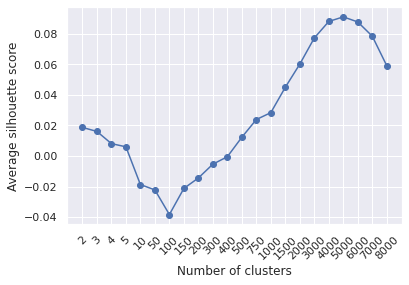

In [30]:
silhouette_scores = pred_cluster_labels["K-means clustering"]["metric_values"]
xs = range(len(ks))

plt.scatter(xs, silhouette_scores)
plt.xticks(xs, ks, rotation=45)
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.plot(xs, silhouette_scores)
plt.show()

In [ ]:
# TODO: Zoom inn på 4000-6000.

2 clusters: max=5641, min=4359, ratio=1.2941041523285157


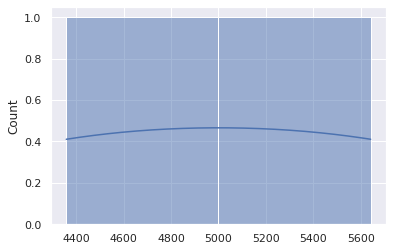

---
3 clusters: max=3624, min=2930, ratio=1.2368600682593858


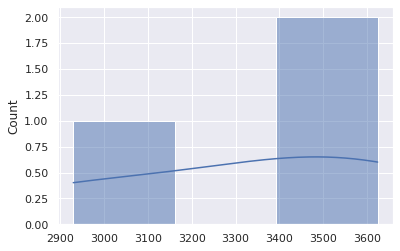

---
4 clusters: max=3136, min=1378, ratio=2.2757619738751815


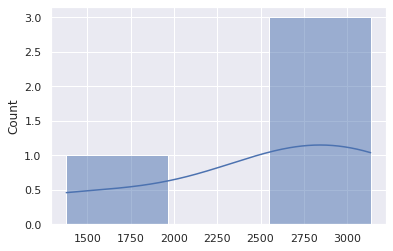

---
5 clusters: max=2656, min=1232, ratio=2.155844155844156


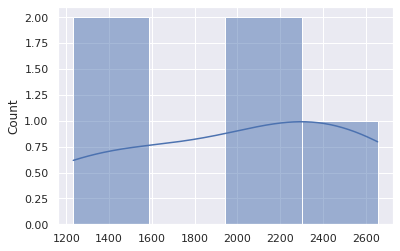

---
10 clusters: max=1797, min=410, ratio=4.382926829268293


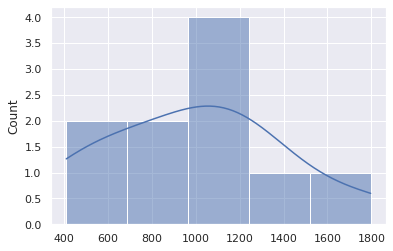

---
50 clusters: max=714, min=11, ratio=64.9090909090909


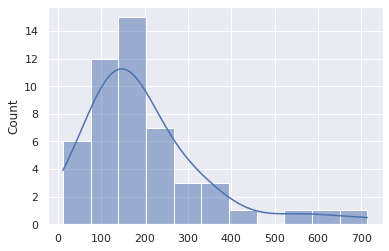

---
100 clusters: max=346, min=5, ratio=69.2


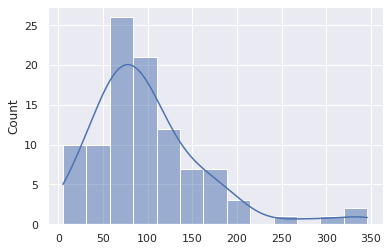

---
150 clusters: max=337, min=3, ratio=112.33333333333333


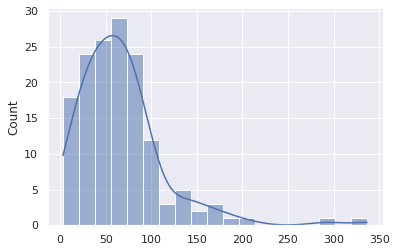

---
200 clusters: max=280, min=1, ratio=280.0


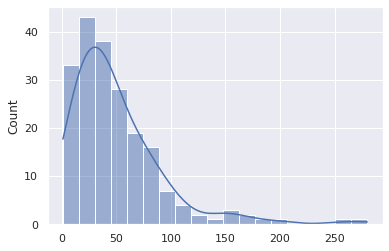

---
300 clusters: max=188, min=1, ratio=188.0


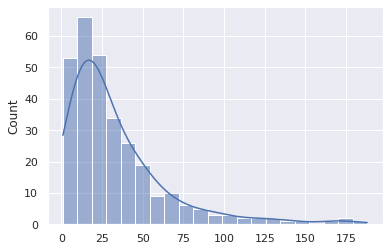

---
400 clusters: max=163, min=1, ratio=163.0


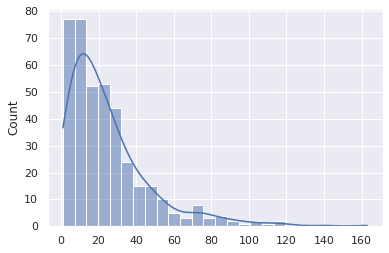

---
500 clusters: max=163, min=1, ratio=163.0


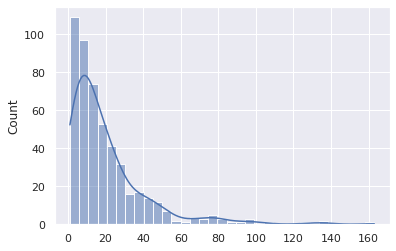

---
750 clusters: max=186, min=1, ratio=186.0


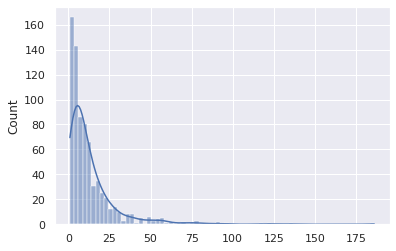

---
1000 clusters: max=186, min=1, ratio=186.0


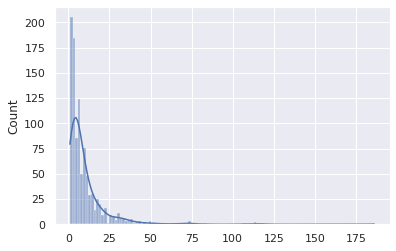

---
1500 clusters: max=181, min=1, ratio=181.0


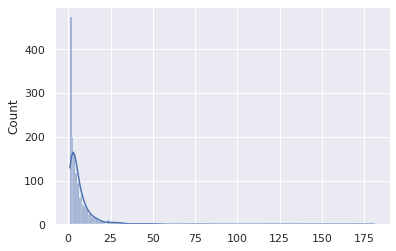

---
2000 clusters: max=164, min=1, ratio=164.0


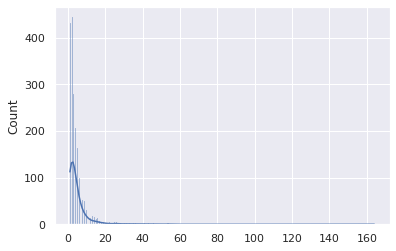

---
3000 clusters: max=138, min=1, ratio=138.0


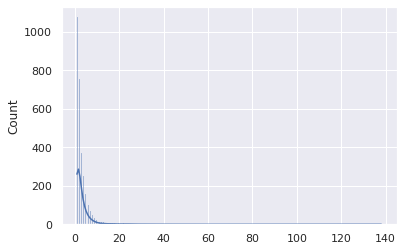

---
4000 clusters: max=139, min=1, ratio=139.0


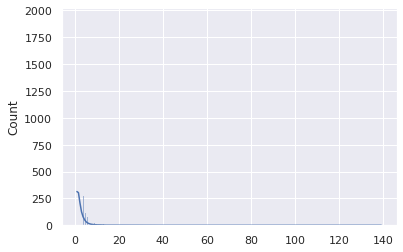

---
5000 clusters: max=61, min=1, ratio=61.0


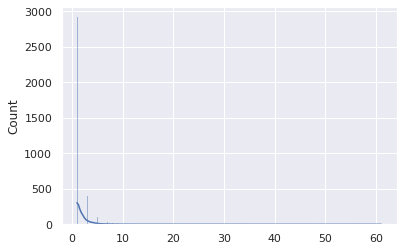

---
6000 clusters: max=106, min=1, ratio=106.0


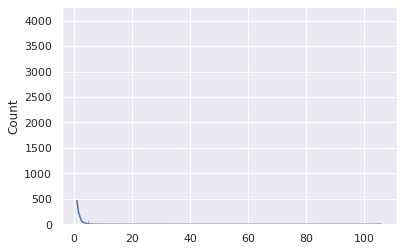

---
7000 clusters: max=92, min=1, ratio=92.0


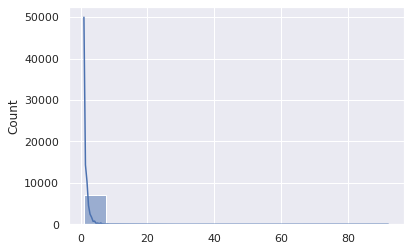

---
8000 clusters: max=49, min=1, ratio=49.0


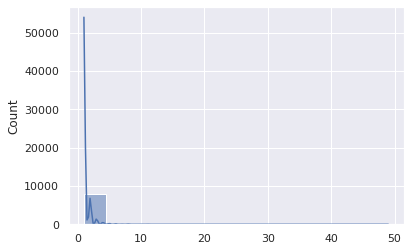

---


In [19]:
# Compute cluster size ratios (maximum cluster size / minimum cluster size)
for labels in pred_cluster_labels["K-means clustering"]["labels"]:
    labels_unique, labels_counts = np.unique(labels, return_counts=True)
    num_clusters = len(labels_unique)
    max_cluster_size = max(labels_counts)
    min_cluster_size = min(labels_counts)
    cluster_size_ratio = max_cluster_size / min_cluster_size
    print(f"{num_clusters} clusters: max={max_cluster_size}, min={min_cluster_size}, ratio={cluster_size_ratio}")
    
    # Plot distribution of cluster sizes
    sns.histplot(labels_counts, kde=True)
    plt.show()
    
    print("---")

In [ ]:
# TODO: Se hvilke ord som forekommer i forskjellige clustre (e.g. største, minste, osv)

In [133]:
def words_in_clusters(cluster_labels: np.ndarray, words: np.ndarray) -> tuple:
    """
    TODO: Docs
    """
    labels_unique, labels_counts = np.unique(cluster_labels, return_counts=True)
    cluster_words = []
    for cluster_label in labels_unique:
        words_in_cluster = words[cluster_labels == cluster_label]
        cluster_words.append(words_in_cluster)
    cluster_words = np.array(cluster_words)
    return cluster_words, labels_counts

In [134]:
cluster_words, cluster_sizes = words_in_clusters(
    cluster_labels=pred_cluster_labels["K-means clustering"]["labels"][-4],
    words=words[:vocab_size]
)

In [141]:
biggest_cluster_idx = np.argmax(cluster_sizes)
smallest_cluster_idx = np.argmin(cluster_sizes[cluster_sizes >= 5])

In [142]:
cluster_words[biggest_cluster_idx]

array(['johnson', 'scott', 'wilson', 'davis', 'miller', 'howard',
       'anderson', 'clark', 'allen', 'harris', 'kennedy', 'wright',
       'marshall', 'carter', 'morris', 'warren', 'mitchell', 'foster',
       'butler', 'wallace', 'harvey', 'montgomery', 'burns', 'armstrong',
       'bailey', 'henderson', 'mcdonald', 'cohen', 'glenn', 'morrison',
       'dale', 'johnston', 'logan', 'crawford', 'griffin', 'ferguson',
       'mann', 'meyer', 'coleman', 'riley', 'davidson', 'boyd', 'sanders',
       'joyce', 'buck', 'patterson', 'peterson', 'schmidt', 'cunningham',
       'parsons', 'hansen', 'williamson', 'jacobs', 'barber', 'stevenson',
       'simmons', 'daniels', 'allison', 'garrett', 'goodman', 'mack'],
      dtype='<U58')

In [143]:
cluster_words[cluster_sizes >= 5][smallest_cluster_idx]

array(['protection', 'protect', 'protected', 'protecting', 'protective'],
      dtype='<U58')

In [ ]:
# TODO: K-mediods (og agglomerative)?